## Load Packages

In [ ]:
library(ggplot2)
library(plyr)
library(reshape2)
library(pomp)
library(magrittr)
library(reshape2)
library(foreach)
stopifnot(packageVersion("pomp")>="1.4.9")

## Base model in **pomp**
We begin by importing the data for the experiment. We will initially load only the data for rep 4 into the **pomp** object. Later, we will describe a function that incorporates all of the data to estimate parameters.

In [ ]:
read.csv("./data/data.csv") %>%subset(weeks <= 40, select=c(weeks,rep,L_obs,P_obs,A_obs)) -> dat
head(dat)

In [ ]:
LPA_model <- pomp(data = subset(dat, rep==4),
              times = "weeks", t0 = 0);

## LPA model
Individuals are categorized as either larvae, pupae, or adults. At time $t$, the number of each is given by $L_t$, $P_t$ and $A_t$, respectively. The time unit is 2 weeks, which is the average amount of time spent in the larval stage in this experiment.

Eggs are produced at a rate proportional to the number of adults. Eggs are cannibalized by larvae at a rate $c_{el}$, and by adults at a rate $c_{ea}$. So, the probability of an egg surviving 1 time unit in the presence of $L$ larvae is $\exp(-c_{el}L)$. Likewise, the probability of an egg surving 1 time unit in the presence of $A$ adults is $\exp(-c_{ea}A)$.

Larvae have a mortality rate of $\mu_l$ over the course of 2 weeks. If they survive, we assume they become pupae. Pupae are cannibalized by adults at a rate of $-c_{pa}$. So the probability that a pupa will survive 1 time unit in the presence of A adults is $\exp(-c_{pa} A)$. If they survive, we assume they become adults. - Adults have a mortality rate of $\mu_A$ over the course of 1 time unit.

Thus, the full LPA model is

$$\begin{aligned}
L_t &= b A_{t-1} \exp{(-c_{el} L_{t-1} - c_{ea} A_{t-1})} \\
P_t &= L_{t-1} (1 - \mu_1) \\
A_t &= P_{t-1} \exp{(-c_{pa} A_{t-1})} + A_{t-1}(1 - \mu_a)
\end{aligned}$$

We can use this as the deterministic skeleton of a **pomp** model:

In [ ]:
skel <- Csnippet(' DL = b * A * exp(-cel * L - cea * A);
                   DP = L * (1 - ul);
                   DA = P * exp(-cpa * A) + A * (1 - ua);');
LPA_model <- pomp(LPA_model,
    skeleton = map(skel, delta.t=2),
    statenames = c('L', 'P', 'A'),
    paramnames = c('b', 'cel', 'cea', 'cpa', 'ua', 'ul'));

Each experimental repetition was initialized by placing 250 larvae, 5 pupae, and 100 adults in a jar. So we simply initialize our process with the following `Csnippet`:

In [ ]:
init <- Csnippet(' L = 250;
                   P = 5;
                   A = 100;');

To incorporate stochasticity to our model, we need to specify a function for $f_{X_n | X_{n - 1}}$. Dennis et al begin with the LPA model specified above, and modify it as follows.

* $L_t$ is Poisson distributed with mean $b a_{t-1} \exp{(-c_{el} l_{t-1} - c_{ea} a_{t-1})}$.
* Each larva is given a probability $(1 - \mu_l)$ of surviving a 2-week period, at which point we assume it becomes a pupa. Therefore, $P_t$ is binomial distributed with $n = l_{t-1}$ and $p = (1 - \mu_l)$.
* Over a 2-week period, we assume that each pupa either survives to become an adult, or dies. Since pupae are cannibalized by adults, the survival probaility is $\exp(-c_{pa}a_{t-1})$. The survivors are called "recruits", and given by $R_t$.
* Over a 2-week period, we assume that adult beetles survive with probability $(1 - \mu_a)$. Thus, the number of survivors $S_t$ is binomially distributed.

$$\begin{aligned}
L_t &= \text{Poisson}(ba_{t-1} \exp[-c_{el}l_{t-1} - c_{ea}a_{t-1}])\\
P_t &= \text{binomial}(l_{t - 1}, (1 - \mu_l)) \\
R_t &= \text{binomial}(p_{t-1}, \exp[-c_{pa}a_{t-1}]) \\
S_t &= \text{binomial}(a_{t-1}, [1 - \mu_a]) \\
A_t &= R_t + S_t
\end{aligned}$$

We can write a Csnippet to simulate this process as follows:

In [ ]:
rproc <- discrete.time.sim( 
         step.fun=Csnippet(' L = rpois(b * A * exp(-cel * L - cea * A));
                             P = rbinom(L, (1 - mu_L));
                             int R = rbinom(P, exp(-cpa * A));
                             int S = rbinom(A, (1 - mu_A));
                             A = R + S;'),
         delta.t=2);

We assume the measurement error is negligable, and therefore make no attempt to model it. As a result, our `rmeasure` function simply assigns the value of the $L$, $P$, and $A$ states to the respective observation values.

$$\begin{aligned}
\sqrt{L_t} &= \sqrt{bA_{t-1} \exp(-c_{el} L_{t-1} - c_{ea} A_{t-1})} + E_{1t}\\
\sqrt{P_t} &= \sqrt{L_{t-1}(1 - \mu_l)} + E_{2t}\\
\sqrt{A_t} &= \sqrt{P_{t-1} exp(-c_{pa}A_{t-1}) + A_{t-1}(1 - \mu_a)} + E_{3t}\\
\end{aligned}$$

In [ ]:
rmeas <- Csnippet("
                    L_obs = L;
                    P_obs = P;
                    A_obs = A;");

In [ ]:
rproc <- discrete.time.sim( 
         step.fun=Csnippet(' double e1 = rnorm(0,sigma_1);
                             double e2 = rnorm(0,sigma_2);
                             double e3 = rnorm(0,sigma_3);
                             L = (sqrt(b * A * exp(-cel * L - cea * A)) + e1)*(sqrt(b * A * exp(-cel * L - cea * A)) + e1);
                             P = (sqrt(L * (1 - ul)) + e2)*(sqrt(L * (1 - ul)) + e2);
                             A = (sqrt(P * exp(-cpa * A) + A * (1 - ua)) + e3)*(sqrt(P * exp(-cpa * A) + A * (1 - ua)) + e3);'),
         delta.t=2);

We assume the measurement error is negligable, and therefore make no attempt to model it. As a result, our `rmeasure` function simply assigns the value of the $L$, $P$, and $A$ states to the respective observation values.

In [ ]:
rmeas <- Csnippet("
                    L_obs = L;
                    P_obs = P;
                    A_obs = A;");

Along the same lines, `dmeasure` can be defined as a pmf, which is 1 when the observations match the state values, and 0 otherwise

In [ ]:
dmeas <- Csnippet(" double eps = 0.000001;
                    if((abs(L_obs - L) > eps) ||
                    (abs(P_obs - P) > eps) ||
                    (abs(A_obs - A) > eps)) {
                    lik = 0;
                    } else {
                    lik = 1;
                    }");

We are in the unusual position of being able to define a `dprocess` function.

In [ ]:
dproc <- onestep.dens(dens.fun=function(x1,x2,t1,t2,params,...){
    stopifnot(t2==t1+2L)
    with(as.list(params),{
      mu_l <- sqrt(b * x1["A"] * exp(-cel*x1["L"] - cea*x1["A"]))
      mu_p <- sqrt(x1["L"] * (1 - ul))
      mu_a <- sqrt(x1["P"] * exp(-cpa * x1["A"]) + x1["A"] * (1 - ua))
      
      likl <- dnorm(sqrt(x2["L"]), mean = mu_l, sd = sigma_1,log=TRUE)
      likp <- dnorm(sqrt(x2["P"]), mean = mu_p, sd = sigma_2,log=TRUE)
      lika <- dnorm(sqrt(x2["A"]), mean = mu_a, sd = sigma_3,log=TRUE)
      if(ua < 0){lika = -Inf}
      likl + likp + lika
    })});

Update the model

In [ ]:
LPA_model <- pomp(LPA_model,
                  initializer=init,
                  rprocess=rproc,
                  rmeasure=rmeas,
                  dmeasure=dmeas,
                  dprocess=dproc,
                  statenames = c("L", "P", "A"),
                  paramnames = c("b", "cea", "cel", "cpa", "ua", "ul", "sigma_1", "sigma_2", "sigma_3"))

In [ ]:
dat %>%
  melt(id=c("weeks","rep")) %>%
  acast(variable~rep~weeks) -> datarray

statearray <- datarray
rownames(statearray) <- c("L","P","A")

# Import and organize the parameters for the model
paramarray <- as.matrix(read.csv('./data/params.csv'))
row.names(paramarray) <- c("b", "cea", "cel", "cpa", "ua", "ul", "sigma_1", "sigma_2", "sigma_3")
colnames(paramarray) <- 1:24

In [ ]:
params1 <- c(b = 10.45,
                   cea = 0.01310,
                   cel = 0.01731,
                   cpa = 0.004619,
                   ua = 0.007629,
                   ul = 0.2000,
                   sigma_1 = 1.621,
                   sigma_2 = 0.7375,
                   sigma_3 = 0.01212)

In [ ]:
f2 <- function(par) {
  p <- paramarray
  p[c('b', 'cea','cel','ul','sigma_1','sigma_2','sigma_3'),] <-
      c( par['b'],
         par['cea'],
         par['cel'],
         par['ul'],
         par['sigma_1'],
         par['sigma_2'],
         par['sigma_3'])
  p['ua',c(4, 11, 24)] <- par['ua']
  p['cpa',c(4, 11, 24)] <- par['cpa']
  sum(dprocess(LPA_model,x=statearray,params=p,times=time(model),log=TRUE))
}

In [ ]:
optim(fn = f2, 
      control = c(fnscale=-1, maxit=10000),
      par = params1[c('b', 'cea','cel', 'cpa','ua','ul','sigma_1','sigma_2','sigma_3')]) -> fit2

In [ ]:
plot(A~time, data=simulate(LPA_model, params = params1,as.data.frame=T),type = 'b')

# New Stuff

In [1]:
library(ggplot2)
library(plyr)
library(reshape2)
library(pomp)
library(magrittr)
library(reshape2)
library(foreach)
stopifnot(packageVersion("pomp")>="1.4.9")

In [2]:
read.csv("./data/data.csv") %>%subset(weeks <= 40, select=c(weeks,rep,L_obs,P_obs,A_obs)) -> dat
dat$E_obs <- 0
dat %>%
  melt(id=c("weeks","rep")) %>%
  acast(variable~rep~weeks) -> datarray;

In [3]:
stages.E <- 7
stages.L <- 7
stages.P <- 7
stages.A <- 1

In [4]:
glob_snippet <- Csnippet(sprintf("
#include <math.h>
#define ESTAGES %d
#define LSTAGES %d
#define PSTAGES %d
#define ASTAGES %d
#define L_0 250
#define P_0 5
#define A_0 100
", stages.E, stages.L, stages.P, stages.A))

In [5]:
init_snippet <- Csnippet("
double *E = &E1;
double *L = &L1;
double *P = &P1;

double gamma_E = (ESTAGES / tau_E) * exp((-cel * L_0 - cea * A_0) / ESTAGES);
double gamma_L = (LSTAGES / tau_L) * (1 - mu_L);
double gamma_P = (PSTAGES / tau_P) * exp((-cpa * A_0) / ESTAGES);

double mu_e = (ESTAGES / tau_E) * (1 - exp((-cel * L_0 - cea * A_0) / ESTAGES));
double mu_l = (LSTAGES / tau_L) * mu_L;
double mu_p = (PSTAGES / tau_P) * (1 - exp((-cpa * A_0) / ESTAGES));

double L_rate[LSTAGES] = {0};
double P_rate[PSTAGES] = {0};

int k;
for (k = 0; k < LSTAGES; k++) L_rate[k] = pow(gamma_L/(gamma_L + mu_l), k);
for (k = 0; k < PSTAGES; k++) P_rate[k] = pow(gamma_P/(gamma_P + mu_p), k);

for (k = 0; k < ESTAGES; k++) E[k] = 0;
reulermultinom(LSTAGES, L_0, &L_rate[0], 1, &L[0]);
reulermultinom(PSTAGES, P_0, &P_rate[0], 1, &P[0]);
A = 100;")

In [6]:
rproc_snippet <- 
Csnippet("
double *E = &E1;
double *L = &L1;
double *P = &P1;

int k;
double E_tot = 0;
double L_tot = 0;
double P_tot = 0;
for (k = 0; k < ESTAGES; k++) E_tot += E[k];
for (k = 0; k < LSTAGES; k++) L_tot += L[k];
for (k = 0; k < PSTAGES; k++) P_tot += P[k];

double gamma_E = (ESTAGES / tau_E) * exp((-cel * L_tot - cea * A) / ESTAGES);
double gamma_L = (LSTAGES / tau_L) * (1 - mu_L);
double gamma_P = (PSTAGES / tau_P) * exp((-cpa * A) / ESTAGES);

double mu_e = (ESTAGES / tau_E) * (1 - exp((-cel * L_tot - cea * A) / ESTAGES));
double mu_l = (LSTAGES / tau_L) * mu_L;
double mu_p = (PSTAGES / tau_P) * (1 - exp((-cpa * A) / ESTAGES));

double rate[2], etrans[28], ltrans[28], ptrans[28], adeath;

// Calculate who goes where
for (k = 0; k < ESTAGES; k++) {
rate[0] = gamma_E;
rate[1] = mu_e;
reulermultinom(2,E[k],&rate[0],1,&etrans[2*k]);
}

for (k = 0; k < LSTAGES; k++) {
rate[0] = gamma_L;
rate[1] = mu_l;
reulermultinom(2,L[k],&rate[0],1,&ltrans[2*k]);
}

for (k = 0; k < PSTAGES; k++) {
rate[0] = gamma_P;
rate[1] = mu_p;
reulermultinom(2,P[k],&rate[0],1,&ptrans[2*k]);
}

reulermultinom(1,A,&mu_A,1,&adeath);

// Bookkeeping
for (k = 0; k < ESTAGES; k++) {
E[k] -= (etrans[2*k]+etrans[2*k+1]);
E[k+1] += etrans[2*k]; // E[ESTAGES] == L[0]!!
}

E[0] += rpois(b*A);

for (k = 0; k < LSTAGES; k++) {
L[k] -= (ltrans[2*k]+ltrans[2*k+1]);
L[k+1] += ltrans[2*k]; // L[LSTAGES] == P[0]!!
}

for (k = 0; k < PSTAGES; k++) {
P[k] -= (ptrans[2*k]+ptrans[2*k+1]);
P[k+1] += ptrans[2*k]; // P[PSTAGES] == A[0]!!
}
A -= adeath;
")

In [7]:
dmeas_snippet <-Csnippet(
"
const double *E = &E1;
const double *L = &L1;
const double *P = &P1;

int k;
double E_tot = 0;
double L_tot = 0;
double P_tot = 0;
for (k = 0; k < ESTAGES; k++) E_tot += E[k];
for (k = 0; k < LSTAGES; k++) L_tot += L[k];
for (k = 0; k < PSTAGES; k++) P_tot += P[k];

/*
double eps = 0.000001;
if((abs(L_obs - L_tot) > eps) ||
   (abs(P_obs - P_tot) > eps) ||
   (abs(A_obs - A) > eps)) {
  lik = 0;
} else {
  lik = 1;
}*/

lik =   log(pnorm(L_obs + 0.5, L_tot, meas_sd, 1, 0) - pnorm(L_obs - 0.5, L_tot, meas_sd, 1, 0)) +
        log(pnorm(P_obs + 0.5, P_tot, meas_sd, 1, 0) - pnorm(P_obs - 0.5, P_tot, meas_sd, 1, 0)) +
        log(pnorm(A_obs + 0.5, A,     meas_sd, 1, 0) - pnorm(A_obs - 0.5, A,     meas_sd, 1, 0));

if(isnan(lik))
{
printf(\"\\n\\nL_tot %f\", L_tot);
printf(\"\\nP_tot %f\", P_tot);
printf(\"\\nA_tot %f\", A);
printf(\"\\nsd    %f\", meas_sd);
printf(\"\\nb     %f\", b);
printf(\"\\ncea   %f\", cea);
printf(\"\\ncpa   %f\", cpa);
printf(\"\\nmu_A  %f\", mu_A);
printf(\"\\nmu_L  %f\", mu_L);
printf(\"\\ntau_E %f\", tau_E);
printf(\"\\ntau_L %f\", tau_L);
printf(\"\\ntau_P %f\", tau_P);
}


lik = (give_log) ? lik : exp(lik);

")

In [8]:
rmeas_snippet <- 
Csnippet("
const double *E = &E1;
const double *L = &L1;
const double *P = &P1;

int k;
double E_tot = 0;
double L_tot = 0;
double P_tot = 0;
for (k = 0; k < ESTAGES; k++) E_tot += E[k];
for (k = 0; k < LSTAGES; k++) L_tot += L[k];
for (k = 0; k < PSTAGES; k++) P_tot += P[k];

/*
E_obs = E_tot;
L_obs = L_tot;
P_obs = P_tot;
A_obs = A;
*/

E_obs = E_tot;
L_obs = nearbyint(rnorm(L_tot, meas_sd));
P_obs = nearbyint(rnorm(P_tot, meas_sd));
A_obs = nearbyint(rnorm(A, meas_sd));

")

In [9]:
from_est <- Csnippet("
Tb = exp(b);
Tcea = expit(cea);
Tcel = expit(cel);
Tcpa = expit(cpa);
Tmu_A = expit(mu_A);
Tmu_L = expit(mu_L);
Ttau_E = exp(tau_E);
Ttau_L = exp(tau_L);
Ttau_P = exp(tau_P);
Tmeas_sd = exp(meas_sd);
")

to_est <- Csnippet("
Tb = log(b);
Tcea = logit(cea);
Tcel = logit(cel);
Tcpa = logit(cpa);
Tmu_A = logit(mu_A);
Tmu_L = logit(mu_L);
Ttau_E = log(tau_E);
Ttau_L = log(tau_L);
Ttau_P = log(tau_P);
Tmeas_sd = log(meas_sd);
")

In [10]:
pomp(
  data = subset(dat, rep==4),
  times="weeks", t0=0,
  obsnames = c("E_obs", "L_obs", "P_obs", "A_obs"),
  statenames = c(sprintf("E%d",1:stages.E),sprintf("L%d",1:stages.L),sprintf("P%d",1:stages.P),"A"),
  paramnames = c("b", "cea", "cel", "cpa", "mu_A", "mu_L", "tau_E", "tau_L", "tau_P", "meas_sd"),
  globals = glob_snippet,
  initializer = init_snippet,
  rprocess = discrete.time.sim(
    step.fun = rproc_snippet,
    delta.t = 1/7),
  dmeasure = dmeas_snippet,
  rmeasure = rmeas_snippet,
  toEstimationScale = to_est,
  fromEstimationScale = from_est,
  params = c("b"=1.18702207924403,
             "cea"=0.0132088702404268,
             "cel"=0.0172244842038504,
             "cpa"=0.00466955565765198,
             "mu_A"=1.89532307252467e-05,
             "mu_L"=0.0158937470126093,
             "tau_E"=15.7219226675806,
             "tau_L"=5.18906255435284,
             "tau_P"=18.0248791283609,
             "meas_sd" = 10)) -> model

In [11]:
defaultparams <- model@params

In [12]:
#ssr <- function(par) {
#  total <- 0
#  if(min(par) < 0){
#    total <- -Inf
#  }
#  
#  if(max(par[c('cea', 'cel', 'cpa')]) > 1){
#    total <- -Inf
#  }
#
#  sim <- simulate(model, nsim = 200, params = par)
#
#  for(i in 1:200){
#    for(j in c(4)){ #, 11, 24)){
#      total = total + sum(rowSums((datarray[c("L_obs", "P_obs", "A_obs"),j,] - obs(sim[[i]])[c('L_obs','P_obs','A_obs'),])^2)^0.5)
#    }
#  }
#  total
#}

In [13]:
#fit1 <- optim(fn=ssr, par=defaultparams, control=c(maxit=100000))

In [14]:
#model <- pomp(model, params=fit1$par)

In [15]:
multiplot <- function(..., plotlist=NULL, cols) {
    require(grid)

    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)

    numPlots = length(plots)

    # Make the panel
    plotCols = cols                          # Number of columns of plots
    plotRows = ceiling(numPlots/plotCols) # Number of rows needed, calculated from # of cols

    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(plotRows, plotCols)))
    vplayout <- function(x, y)
        viewport(layout.pos.row = x, layout.pos.col = y)

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
        curRow = ceiling(i/plotCols)
        curCol = (i-1) %% plotCols + 1
        print(plots[[i]], vp = vplayout(curRow, curCol ))
    }

}

Loading required package: grid


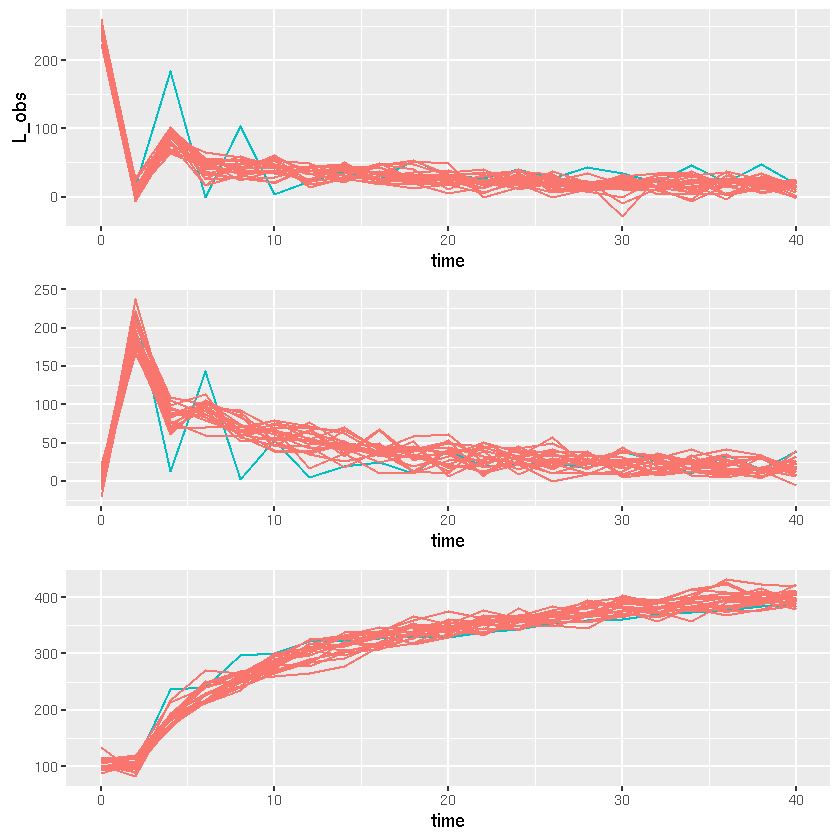

In [16]:
sims <- simulate(model, nsim=20,as.data.frame=TRUE,include.data=TRUE)
pl <- ggplot(sims,mapping=aes(x=time,y=L_obs,group=sim,color=sim=="data"))+geom_line()+guides(color=FALSE)
pp <- ggplot(sims,mapping=aes(x=time,y=P_obs,group=sim,color=sim=="data"))+geom_line()+guides(color=FALSE)
pa <- ggplot(sims,mapping=aes(x=time,y=A_obs,group=sim,color=sim=="data"))+geom_line()+guides(color=FALSE)
multiplot(pl, pp, pa, cols=1);

In [17]:
pf <- pfilter(model, params = defaultparams, Np=1000)
logLik(pf)

Warning message:
: in ‘pfilter’: 1 filtering failure occurred.

[1] -316.4906

In [18]:
library(foreach);
library(doParallel);
registerDoParallel();

Loading required package: iterators
Loading required package: parallel


In [19]:
stew(file="./output/pf.rda",{
  t_pf <- system.time(
    pf <- foreach(i=1:10,.packages='pomp',
                  .options.multicore=list(set.seed=TRUE),
                  .export=c("model")
    ) %dopar% {
      pfilter(model,params=defaultparams,Np=10000)
    }
  )
  n_pf <- getDoParWorkers()
},seed=625904618,kind="L'Ecuyer")

(L_pf <- logmeanexp(sapply(pf,logLik),se=TRUE))

se 
-314.563820    0.886026

In [20]:
results <- as.data.frame(as.list(c(coef(pf[[1]]),loglik=L_pf[1],loglik=L_pf[2])))
#write.csv(results,file="./output/model_params.csv",row.names=FALSE)

In [21]:
stew(file="./output/box_search_local.rda",{
  t_local_mif <- system.time({
    mifs_local <- foreach(i=1:20,
                          .packages='pomp',
                          .combine=c, 
                          .options.multicore=list(set.seed=TRUE),
                          .export=c("model")
    ) %dopar%  
    {
      mif2(
        model,
        start=defaultparams,
        Np=2000,
        Nmif=50,
        cooling.type="geometric",
        cooling.fraction.50=0.5,
        transform=TRUE,
        rw.sd=rw.sd(b=0.02, cea=0.02, cel=0.02, cpa=0.02, mu_A=0.02, mu_L=0.02,
                    tau_E=0.02, tau_L=0.02, tau_P=0.02, meas_sd = 0.02)
      )
    }
  })
},seed=482947940,kind="L'Ecuyer")

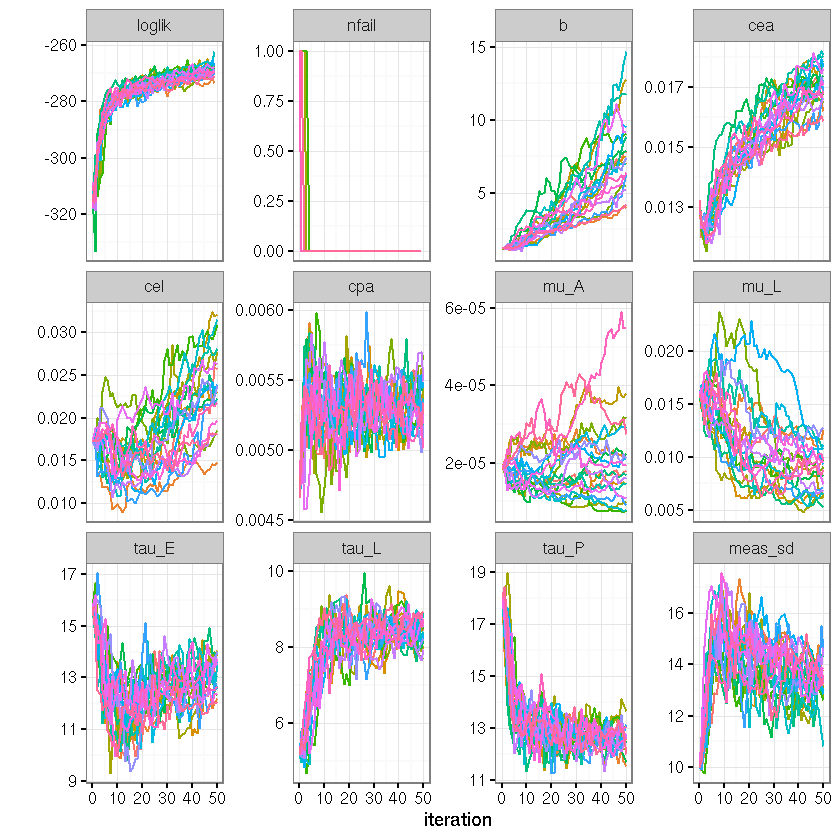

In [22]:
ggplot(data=melt(conv.rec(mifs_local)),
       aes(x=iteration,y=value,group=L1,color=factor(L1)))+
  geom_line()+
  guides(color=FALSE)+
  facet_wrap(~variable,scales="free_y")+
  theme_bw()

In [23]:
stew(file="./output/lik_local.rda",{
  t_local_eval <- system.time({
    results_local <- foreach(mf=mifs_local,
                             .packages='pomp',
                             .combine=rbind,
                             .options.multicore=list(set.seed=TRUE)
    ) %dopar% 
    {
      evals <- replicate(10, logLik(pfilter(mf,Np=20000)))
      ll <- logmeanexp(evals,se=TRUE)
      c(coef(mf),loglik=ll[1],loglik=ll[2])
    }
  })
},seed=900242057,kind="L'Ecuyer")
results_local <- as.data.frame(results_local)

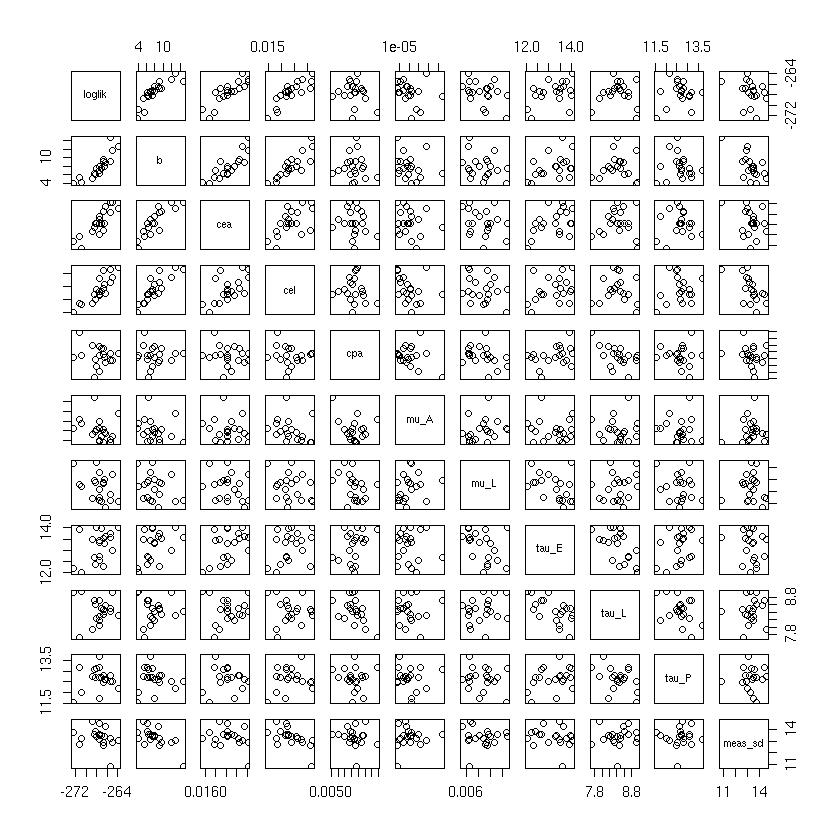

In [24]:
pairs(~loglik+b+cea+cel+cpa+mu_A+mu_L+tau_E+tau_L+tau_P+meas_sd,data=results_local)

In [25]:
results <- rbind(results,results_local[names(results)])
#write.csv(results,file="./output/model_params.csv",row.names=FALSE)

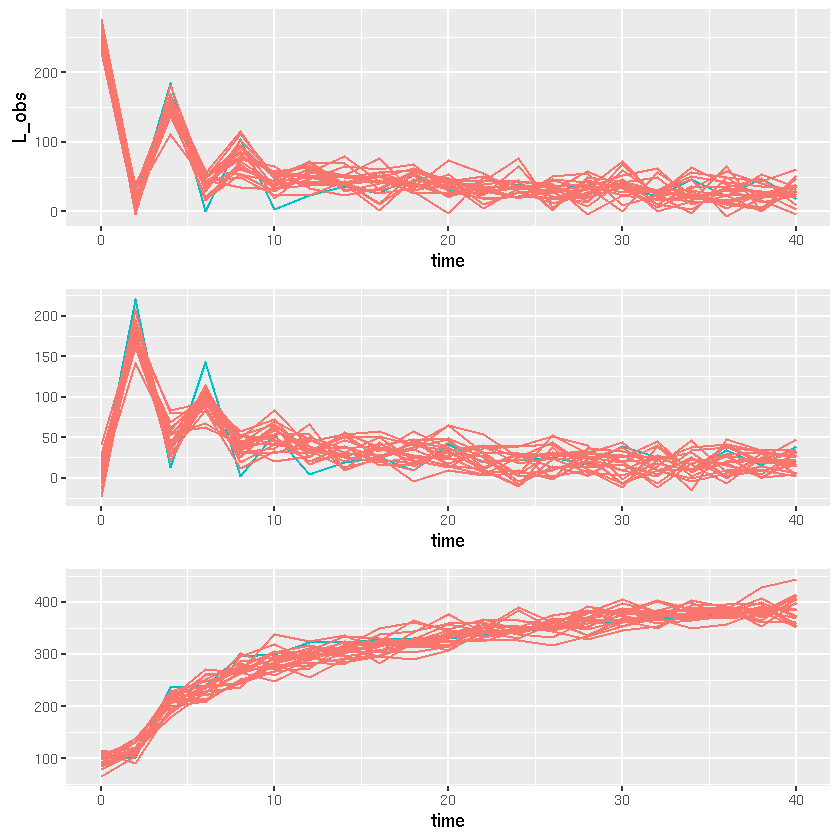

In [32]:
optim_params <- unlist(results_local[which.max(results_local$loglik),])
sims <- simulate(model, params = optim_params, nsim=20,as.data.frame=TRUE,include.data=TRUE)
pl <- ggplot(sims,mapping=aes(x=time,y=L_obs,group=sim,color=sim=="data"))+geom_line()+guides(color=FALSE)
pp <- ggplot(sims,mapping=aes(x=time,y=P_obs,group=sim,color=sim=="data"))+geom_line()+guides(color=FALSE)
pa <- ggplot(sims,mapping=aes(x=time,y=A_obs,group=sim,color=sim=="data"))+geom_line()+guides(color=FALSE)
multiplot(pl, pp, pa, cols=1);